# Hougan-Watson kinetics

Consider CO oxidation in a catalytic fixed-bed reactor operating isothermally at 838 K and 1.0 atm.
\begin{align}
CO + \frac{1}{2}O_2\rightarrow CO_2
\end{align}
The following rate expression and parameters are adapted from a research paper. The rate expression inside the catalyst particle is assumed to be of the form
\begin{align}
r = \frac{kC_{CO}C_{O2}}{1+KC_{CO}}
\end{align}
where 
\begin{align}
k=8.73\times 10^{12}\exp(-13,500/T) [cm^3/mol/s]\\
K = 8.099\times 10^6 \exp(409/T) [cm^3/mol]\\
D_{CO}=0.0487 [cm^2/s]
\end{align}
in which T is in Kelvin. The catalyst pellet radius is 0.1 cm. The feed to the reactor consists of 2 mol % CO, 10 mol % O$_2$, no CO$_2$, and the remainder inert. The bed porosity (volume of pellets compared to total reactor volume) is 70%. We want to find the volume of the reactor that reaches 95% conversion. The flow rate in is 792 L/s. 

## Calculate the Thiele modulus at the inlet and outlet of the reactor


In [3]:
import numpy as np

T = 838 #K 
P = 1.0 #atm 
R = 0.08206  #L·atm/K·mol
Ct_in = P / (R*T*1000)   # mol/cm3
k = 8.73 * 10**12 * np.exp(-13500/T) #cm3/mol/s
K = 8.099 * 10**6 * np.exp(409/T)  #cm3/mol
D_CO = 0.0487  #cm2/s
r = 0.1 # cm
a = r/3 # cm
Por = 0.7
X = 0.95
v0 = 792000 #cm3/s
                #CO   O2  CO2   I
y_in = np.array([0.02, 0.1, 0, 0.88])
C_in = Ct_in * y_in     # mol/cm3
F_in = Ct_in * v0

Alpha = np.array([-1, -0.5, 1, 0])
Xi = y_in[0]*Alpha*X
y_out = y_in + Xi
Ct_out = Ct_in * sum(y_out) / sum(y_in)
C_out = Ct_out * y_out             # mol/cm3

def Th_mod(C):
    Ca, Cb, Cc, Cd = C  #  CO, O2, CO2, Inert
    Phi = K * Ca
    Th_prime = np.sqrt(k * a*a * Cb / D_CO)
    Thiele = (Phi / (1+Phi)) * Th_prime / (np.sqrt(2*(Phi - np.log(1 + Phi))))
    return Thiele

print(f'Thiele modulus at the inlet is {Th_mod(C_in):1.4f} and at the outlet of the reactor is {Th_mod(C_out):1.4f}.')

Thiele modulus at the inlet is 0.0638 and at the outlet of the reactor is 0.1442.


## Calculate the effectiveness factor at the inlet and outlet  of the reactor

In [4]:
def Eta(C):
    Ca, Cb, Cc, Cd = C  #  CO, O2, CO2, Inert
    Eta = 1 / Th_mod(C) * (1 / np.tanh(3 * Th_mod(C)) - 1 / (3 * Th_mod(C)))
    return Eta

print(f'The effectiveness factor at the inlet is {Eta(C_in):1.4f} and at the outlet of the reactor is {Eta(C_out):1.4f}.')

The effectiveness factor at the inlet is 0.9976 and at the outlet of the reactor is 0.9877.


## Calculate and plot the concentration of each species over the volume of the reactor.  

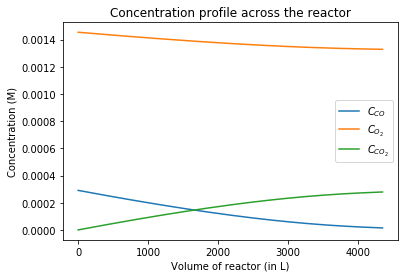

In [6]:
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

F0 = C_in * v0

def dFdV(V, F):
    Fa, Fb, Fc, Fd = F
    v = v0 * sum(F)/sum(F0)
    Ca = Fa / v    # Concentration in mol/cm^3
    Cb = Fb / v
    Cc = Fc / v
    Cd = Fd / v
    
    r = k * Ca * Cb / (1 + K * Ca)  # Ideal rate
    eta = Eta(np.array([Ca,Cb,Cc,Cd]))  # Effectiveness factor
    AR = eta * r    # Actual rate
    
    dFadV = AR * Alpha[0]
    dFbdV = AR * Alpha[1]
    dFcdV = AR * Alpha[2]
    dFddV = AR * Alpha[3]
    
    return [dFadV, dFbdV, dFcdV, dFddV]

def event(V, F):
    Fa, Fb, Fc, Fd = F    
    return F0[0] * 0.05 - Fa

event.terminal = True

Vspan = [0, 20000000]  #cm^3, This high guess since the volume is probably in m^3
h = 10000  # cc
ans = solve_ivp(dFdV, Vspan, F0, dense_output = True, max_step=h, events = event)

Vtot = ans.t_events 
V = ans.t / 1000
F = ans.y
v = v0 * sum(F)/sum(F0)
Ca = F[0] / v * 1000   # Here concentration is in mol/L
Cb = F[1] / v * 1000
Cc = F[2] / v * 1000
Cd = F[3] / v * 1000

plt.plot(V, Ca, label = '$C_{CO}$')
plt.plot(V, Cb, label = '$C_{O_2}$')
plt.plot(V, Cc, label = '$C_{CO_2}$')
plt.xlabel('Volume of reactor (in L)')
plt.ylabel('Concentration (M)')
plt.title('Concentration profile across the reactor')
plt.legend()
plt.show()

In [11]:
V_pellet = Vtot[0][0]
print(f'The total volume of pellets required is: {V_pellet/1000:1.4f} L.')
reactor_V =  V_pellet / 0.7 / 1000
print(f'The total volume of reactor required is: {reactor_V:1.4f} L.')

The total volume of pellets required is: 4348.3849 L.
The total volume of reactor required is: 6211.9784 L.


## Calculate and plot  the Thiele modulus over the length of the reactor

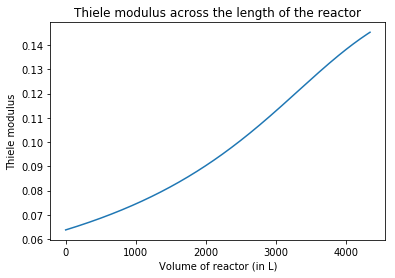

In [12]:
C = np.array([Ca, Cb, Cc, Cd])
Th = []

for i in range(len(ans.t)):
    C = np.array([Ca[i], Cb[i], Cc[i], Cd[i]]) / 1000  # in mol/cm^3
    tm = Th_mod(C)
    Th.append(tm)
    
plt.plot(V, Th)
plt.xlabel('Volume of reactor (in L)')
plt.ylabel('Thiele modulus')
plt.title('Thiele modulus across the length of the reactor')
plt.show()

# Pellet size effects

The first-order irreversible reaction $A->B$ takes place in a 0.3 cm radius spherical catalyst pellet at T=450 K. At 0.7 atm partial of A, the pellet's production rate is $-2.5\times 10^{-5}$mol/g/s. The pellet density is $0.85 g/cm^3$. The effective diffusivity of A in the pellet is $D_A=0.007 cm^2/s$.

## Calculate the surface concentration (the concentration of A in the gas, use ideal gas). 

In [14]:
Pa = 0.7   #atm
T = 450    #K
R = 0.08206  #L·atm/K·mol

Cas = Pa / (R*T)
print(f'The surface concentration is {Cas:1.3e} M.')

The surface concentration is 1.896e-02 M.


## For the 0.3 cm pellet size, write down the rate of production of the particle in terms of the effectiveness factor (and thus Thiele  modulus)

The rate of production can be found as:
*Rate of generation of B = - Rate of generation of A*

Let $r_A$' = Rate of reaction / mass of catalyst , $\rho_p$ = pellet density and $r_m$ = Mean radius of shell at radius r

$\therefore$ Rate of generation of A (at radius, r) = $r_A' \times \rho_p \times 4 \pi r_m^2 dr$

Here, the rate is first order and hence: $r_A' = k C_A$

effectiveness factor: $\eta = \frac{{overall rate}}{{ideal rate}}$ 

$\therefore \eta = \displaystyle\frac{\int_0^R k C_A \times \rho_p \times 4 \pi r_m^2 dr}{\int_0^R k C_{A,s} \times \rho_p \times 4 \pi r_m^2 dr}$
; where: $C_A$ is concentration at radius r and $C_{A,s}$ is concentration on the surface

For the presently used spherical pellet, the 

$ \eta = \frac{1}{\Phi}  \left [\frac{1}{\tanh 3 \Phi} - \frac{1}{3 \Phi} \right]$


## Solve for the Thiele modulus in the 0.3 cm pellet

In [15]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.optimize import fsolve

r = 0.3           # cm
Ra = 2.5* 10**-5  # mol/g/s
Da = 0.007        # cm2/s 
rho = 0.85        # g/cm3 
a = r / 3

def thiele(phi):
    k = Da * (phi / a)**2                                  # /s
    eta = (Ra * rho) / (k * Cas / 1000)
    eta2 = 1/phi * (1 / np.tanh(phi * 3) - 1 / (3 * phi))
    return eta - eta2

Th = fsolve(thiele, 1)
thiele, = np.round(Th,4)
np.set_printoptions(precision=3)
print(f'Thiele modulus is {thiele}.')

ideal_rate = Ra / (1/thiele * (1 / np.tanh(thiele * 3) - 1 / (3 * thiele)))
kval = Da * (thiele / a)**2  
print(f'Ideal rate is {ideal_rate:1.3e} mol/g/s.')

Thiele modulus is 1.9347.
Ideal rate is 5.843e-05 mol/g/s.


## Calculate the thiele modulus for a range of pellet sizes from 1 mm to 5cm and plot the production rate (per volume of pellet) over this size range

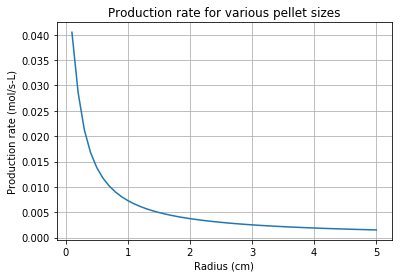

In [16]:
import matplotlib.pyplot as plt

R = np.linspace(0.1, 5)
a = R / 3
phi = np.sqrt(kval * a**2 / Da)
eta = 1/phi * (1 / np.tanh(phi * 3) - 1 / (3 * phi))
Ra = kval * Cas * eta 

plt.plot(R, Ra)
plt.xlabel('Radius (cm)')
plt.ylabel('Production rate (mol/s-L)')
plt.title('Production rate for various pellet sizes')
plt.grid()
plt.show()

# Piazza (2 pts)

This week, either submit a question or answer a question for two points. Post the link to your question or answer

https://piazza.com/class/jl5aabbtksz62s?cid=489